In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

import sys
import os

sys.path.append(os.path.abspath(".."))  # добавляем путь к bensemble/

from methods.variational_renyi import VariationalRenyi

------------------------------------------------------------
Генерация синтетических данных
------------------------------------------------------------

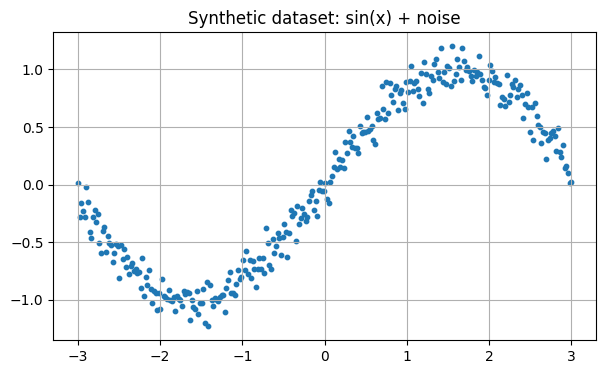

In [2]:
def make_synthetic(n=300, noise=0.1):
    X = torch.linspace(-3, 3, n).unsqueeze(1)
    y = torch.sin(X) + noise * torch.randn_like(X)
    return X, y


X, y = make_synthetic()

plt.figure(figsize=(7, 4))
plt.scatter(X, y, s=10)
plt.title("Synthetic dataset: sin(x) + noise")
plt.grid(True)
plt.show()

------------------------------------------------------------
Простая модель для VR
------------------------------------------------------------
Будем использовать простую модельку

In [3]:
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        return self.net(x)

------------------------------------------------------------
Базовое обучение VR (α = 1, 0.5, 2.0)
------------------------------------------------------------

In [4]:
train_loader = DataLoader(TensorDataset(X, y), batch_size=32, shuffle=True)

alphas = [1.0, 0.5, 2.0]  # VI, "fat tail", conservative
models = {}
histories = {}

for alpha in alphas:
    print(f"\n=== Training VR with α = {alpha} ===")

    model = SimpleNet()
    vr = VariationalRenyi(model, alpha=alpha, initial_rho=-3.0)

    hist = vr.fit(train_loader, num_epochs=250, lr=5e-4, n_samples=5)

    models[alpha] = vr
    histories[alpha] = hist


=== Training VR with α = 1.0 ===

=== Training VR with α = 0.5 ===

=== Training VR with α = 2.0 ===


------------------------------------------------------------
Визуализация распределения неопределённости
------------------------------------------------------------

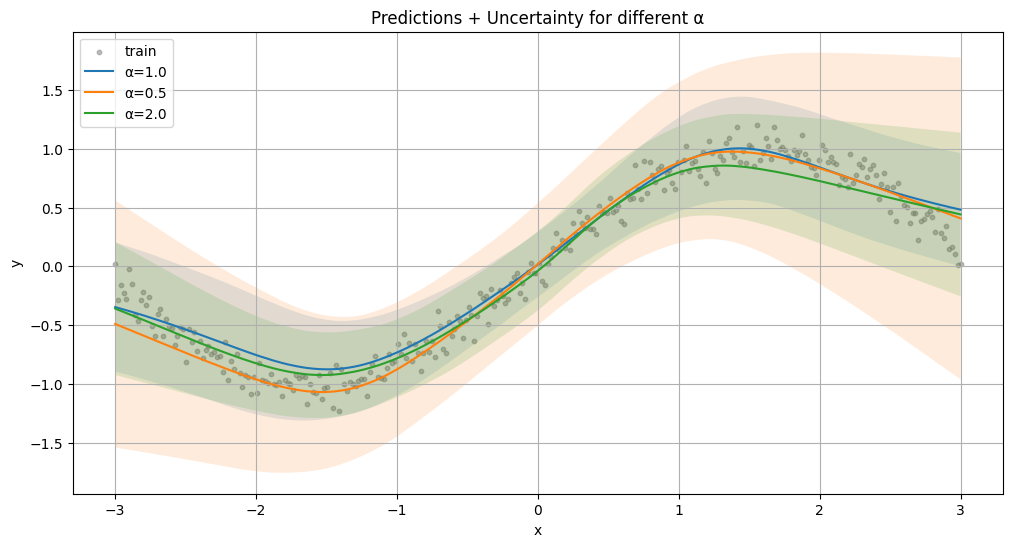

In [5]:
X_test = torch.linspace(-3, 3, 300).unsqueeze(1)

plt.figure(figsize=(12, 6))
plt.scatter(X.numpy(), y.numpy(), s=10, color="gray", alpha=0.5, label="train")

for alpha, vr in models.items():
    mean_pred, samples = vr.predict(X_test, n_samples=100)
    std = samples.std(dim=0)

    X_1d = X_test.squeeze().detach().numpy()
    mean_1d = mean_pred.squeeze().detach().numpy()
    std_1d = std.squeeze().detach().numpy()

    plt.plot(X_1d, mean_1d, label=f"α={alpha}")
    plt.fill_between(X_1d, mean_1d - 2 * std_1d, mean_1d + 2 * std_1d, alpha=0.15)

plt.title("Predictions + Uncertainty for different α")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

------------------------------------------------------------
Графики обучения (loss curves)
------------------------------------------------------------

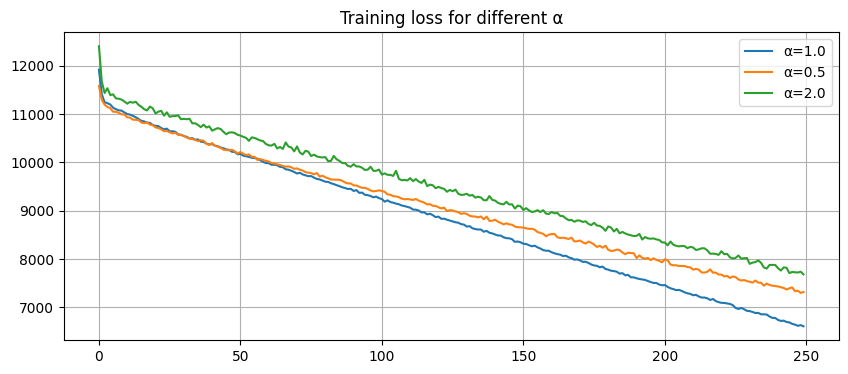

In [6]:
plt.figure(figsize=(10, 4))

for alpha, hist in histories.items():
    plt.plot(hist["train_loss"], label=f"α={alpha}")

plt.title("Training loss for different α")
plt.legend()
plt.grid(True)
plt.show()

------------------------------------------------------------
Сэмплирование моделей (Posterior Samples)
------------------------------------------------------------

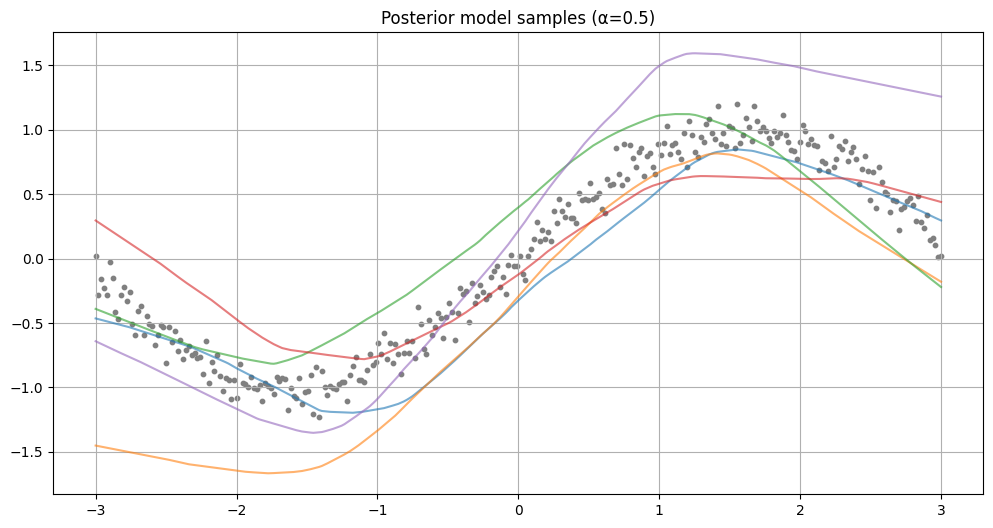

In [7]:
alpha = 0.5
vr = models[alpha]

sampled_models = vr.sample_models(n_models=5)

plt.figure(figsize=(12, 6))
plt.scatter(X, y, color="gray", s=10)

for m in sampled_models:
    with torch.no_grad():
        pred = m(X_test).detach().numpy()
        plt.plot(X_test.numpy(), pred, alpha=0.6)

plt.title(f"Posterior model samples (α={alpha})")
plt.grid(True)
plt.show()

------------------------------------------------------------
VR как тул для исследования Robustness (Noise stress test)
------------------------------------------------------------


=== Retraining VR with HIGH noise, α=1.0 ===

=== Retraining VR with HIGH noise, α=0.5 ===

=== Retraining VR with HIGH noise, α=2.0 ===


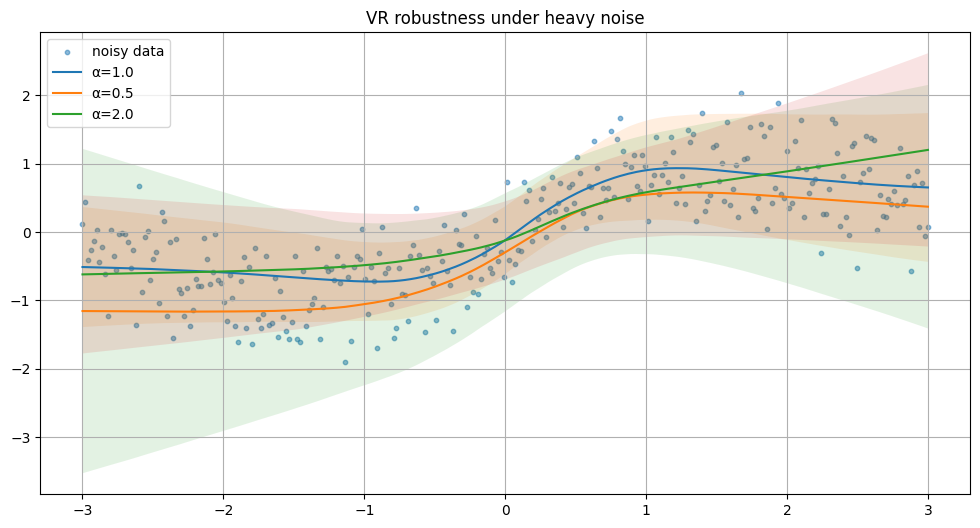

In [13]:
Xn, yn = make_synthetic(noise=0.5)
train_loader_noisy = DataLoader(TensorDataset(Xn, yn), batch_size=32, shuffle=True)

models_noisy = {}

for alpha in alphas:
    print(f"\n=== Retraining VR with HIGH noise, α={alpha} ===")

    model = SimpleNet()
    vr = VariationalRenyi(model, alpha=alpha)

    vr.fit(train_loader_noisy, num_epochs=100, lr=1e-3, n_samples=4)
    models_noisy[alpha] = vr

plt.figure(figsize=(12, 6))
plt.scatter(Xn.numpy(), yn.numpy(), s=10, alpha=0.5, label="noisy data")

for alpha, vr in models_noisy.items():
    mean_pred, samples = vr.predict(X_test, n_samples=50)

    mean_pred_1d = mean_pred.detach().cpu().numpy().reshape(-1)
    std_1d = samples.detach().cpu().numpy().std(axis=0).reshape(-1)
    X_test_1d = X_test.detach().cpu().numpy().reshape(-1)

    plt.plot(X_test_1d, mean_pred_1d, label=f"α={alpha}")

    # доверительный интервал ±2σ
    plt.fill_between(
        X_test_1d, mean_pred_1d - 2 * std_1d, mean_pred_1d + 2 * std_1d, alpha=0.13
    )

plt.title("VR robustness under heavy noise")
plt.grid(True)
plt.legend()
plt.show()

------------------------------------------------------------
VR для out-of-distribution detection (OOD)
------------------------------------------------------------

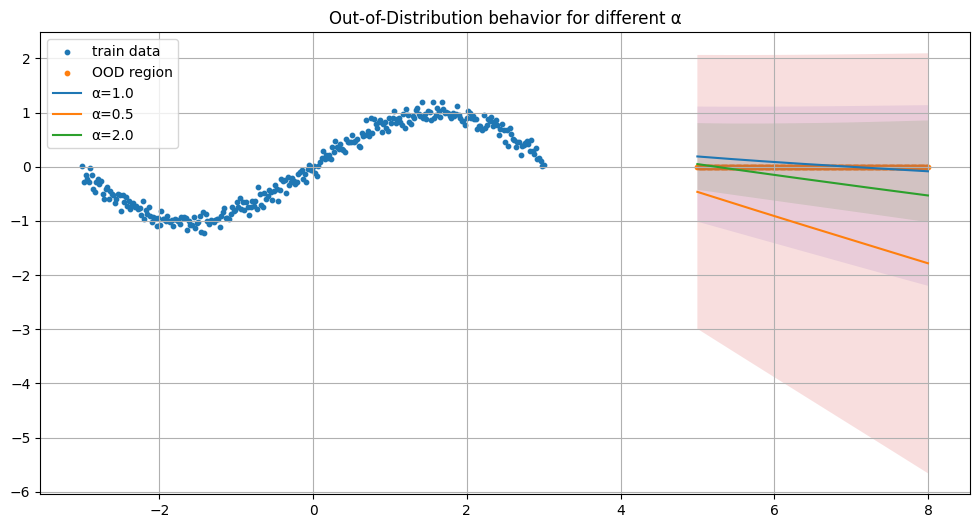

In [15]:
X_ood = torch.linspace(5, 8, 200).unsqueeze(1)

plt.figure(figsize=(12, 6))
plt.scatter(X.numpy(), y.numpy(), s=10, label="train data")
plt.scatter(X_ood.numpy(), torch.zeros_like(X_ood).numpy(), s=10, label="OOD region")

for alpha, vr in models.items():
    mean_pred, samples = vr.predict(X_ood, n_samples=100)

    # Явно приводим к 1D numpy
    X_ood_1d = X_ood.detach().cpu().numpy().reshape(-1)
    mean_pred_1d = mean_pred.detach().cpu().numpy().reshape(-1)
    std_1d = samples.detach().cpu().numpy().std(axis=0).reshape(-1)

    plt.plot(X_ood_1d, mean_pred_1d, label=f"α={alpha}")
    plt.fill_between(
        X_ood_1d, mean_pred_1d - 2 * std_1d, mean_pred_1d + 2 * std_1d, alpha=0.15
    )

plt.title("Out-of-Distribution behavior for different α")
plt.legend()
plt.grid(True)
plt.show()